# SID: Learning to See in the Dark

### Imports

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

!pip install rawpy
import rawpy
import glob
from collections import defaultdict
import requests
import os

In [2]:
print(tf.__version__)

2.17.1


## Prepare the Dataset: Sony Low-Light RAW Image Dataset

In [2]:
def load_raw_image(path):
    """
    load a raw image and extract its Bayer array
    """
    with rawpy.imread(path) as raw:
        raw_img = raw.raw_image_visible.astype(np.float32)

    return raw_img

def pack_raw_image(raw_img):
    """
    convert a Bayer raw image into a 4-channel representation (R, G1, G2, B)

    example input (H, W, 1):  R   G1
                              G2  B
                                
    output (H/2, W/2, 4):    R, G1, G2, B
    """
    H, W = raw_img.shape
    packed_img = np.zeros((H // 2, W // 2, 4), dtype=np.float32)

    packed_img[:,:,0] = raw_img[0::2, 0::2] # R top-left
    packed_img[:,:,1] = raw_img[0::2, 1::2] # G1 top-right
    packed_img[:,:,2] = raw_img[1::2, 0::2] # G2 bottom-left
    packed_img[:,:,3] = raw_img[1::2, 1::2] # B bottom-right

    return packed_img

def normalize_packed_image(packed_img):
    """
    generalized normalization based on the detected max pixel value
    """
    max_value = np.max(packed_img)
    if max_value > 0:
        packed_img /= max_value

    return packed_img

def plot_packed_image(packed_img):
    """
    plot packed image in 4 channels
    """
    fig, axes = plt.subplots(1, 4, figsize=(20, 10))
    titles = ["Reds", "Greens", "Greens", "Blues"]
    
    for i in range(4):
        axes[i].imshow(packed_img[:,:,i], cmap=titles[i])
        axes[i].set_title(titles[i])
        axes[i].axis("off")
    plt.show()


In [3]:
def preprocess_raw_image(image_path):
    """
    preprocess the raw image
        - load
        - pack
        - normalize
    """
    if isinstance(image_path, bytes):
        image_path = image_path.decode("utf-8")
    raw_img = load_raw_image(image_path)
    packed_img = pack_raw_image(raw_img)
    packed_img = normalize_packed_image(packed_img)

    return packed_img


def preprocess_long_image(image_path):
    """
    load and convert a long-exposure raw image to RGB (3-channel)
    """
    if isinstance(image_path, bytes):
        image_path = image_path.decode("utf-8") 
    with rawpy.imread(image_path) as raw:
        rgb_img = raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)  
        rgb_img = rgb_img.astype(np.float32) / 65535.0  # Normalize to [0,1]

    # resize long-exposure image to match short-exposure shape
    H, W = rgb_img.shape[:2]
    rgb_img_resized = cv2.resize(rgb_img, (W // 2, H // 2), interpolation=cv2.INTER_AREA)

    return rgb_img_resized 


def load_and_process_pair(short_path, long_path):
    """
    load and process short, long paths

    Returns:
        (short-exposure, long-exposure) image pair
    """
    short_img = tf.numpy_function(preprocess_raw_image, [short_path], tf.float32)
    long_img = tf.numpy_function(preprocess_long_image, [long_path], tf.float32)

    short_img.set_shape([None, None, 4])  # 4-channel packed input
    long_img.set_shape([None, None, 3]) 

    return short_img, long_img

def create_tf_dataset(file_pairs, batch_size=1, training=True):
    """
    create a Tensorflow dataset
    """
    short_paths, long_paths = zip(*file_pairs)
    dataset = tf.data.Dataset.from_tensor_slices((list(short_paths), list(long_paths)))
    dataset = dataset.map(load_and_process_pair, num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        dataset = dataset.batch(batch_size).shuffle(100).repeat()
    else:
        dataset = dataset.batch(batch_size)
        
    return dataset.prefetch(tf.data.AUTOTUNE)

In [4]:
def plot_paired_raw_image(short_raw_img, long_raw_img):
    """
    plot packed image in 4 channels
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    axes[0].imshow(short_raw_img, cmap="gray")
    axes[0].set_title("Short")
    axes[0].axis("off")

    axes[1].imshow(long_raw_img, cmap="gray")
    axes[1].set_title("Long")
    axes[1].axis("off")
    plt.show()

In [8]:
short_image_path = "/kaggle/input/sid-sony-dataset/Sony/short/00001_00_0.04s.ARW"
short_raw_img = load_raw_image(short_image_path)

long_image_path = "/kaggle/input/sid-sony-dataset/Sony/long/00001_00_10s.ARW"
long_raw_img = load_raw_image(long_image_path)

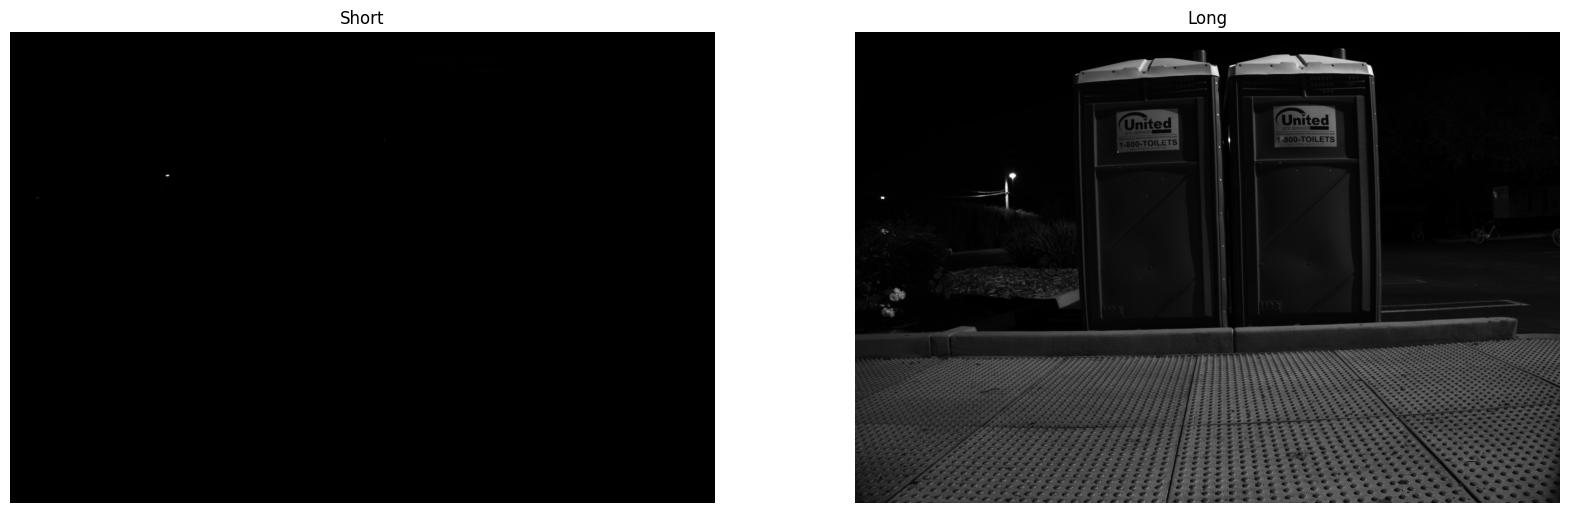

In [14]:
plot_paired_raw_image(short_raw_img, long_raw_img)

In [15]:
short_packed_img = preprocess_raw_image(short_image_path)
long_packed_img = preprocess_raw_image(long_image_path)

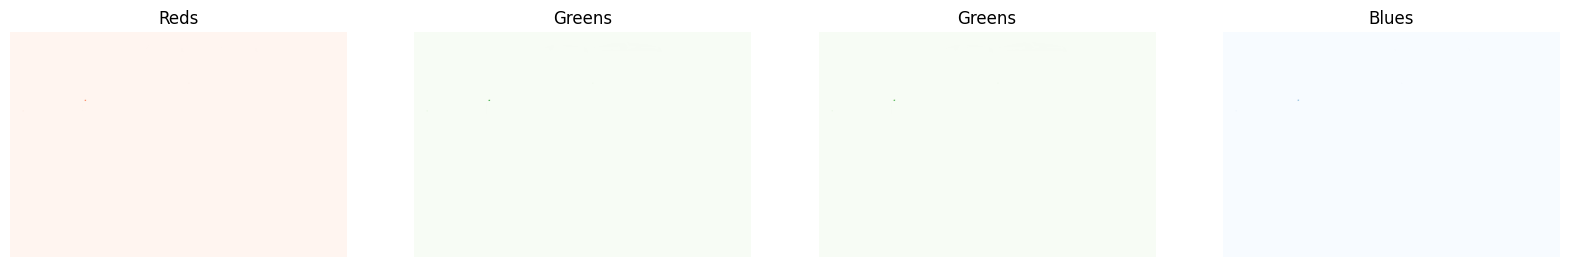

In [16]:
plot_packed_image(short_packed_img)

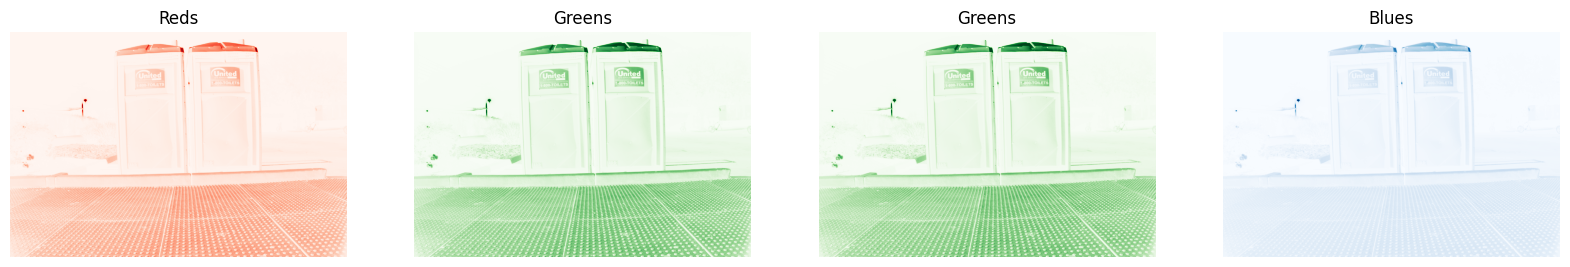

In [17]:
plot_packed_image(long_packed_img)

#### Load the Dataset

- long-exposure images: `{scene_id}_{iso}_{shutter_speed}`
- short-exposure images: `{scene_id}_{variant}_{shutter_speed}`

In [4]:
long_dataset_path = "/kaggle/input/sid-sony-dataset/Sony/long"
short_dataset_path = "/kaggle/input/sid-sony-dataset/Sony/short"

# get all NEF image paths
long_image_paths = sorted(glob.glob(long_dataset_path + "/*.ARW"))
short_image_paths = sorted(glob.glob(short_dataset_path + "/*.ARW"))

print(len(long_image_paths), len(short_image_paths))

231 2697


In [20]:
!ls "/kaggle/input/sid-sony-dataset/Sony/long" | head

00001_00_10s.ARW
00002_00_10s.ARW
00004_00_10s.ARW
00009_00_10s.ARW
00010_00_10s.ARW
00012_00_10s.ARW
00013_00_10s.ARW
00014_00_10s.ARW
00015_00_10s.ARW
00017_00_10s.ARW


In [21]:
!ls "/kaggle/input/sid-sony-dataset/Sony/short" | head

00001_00_0.04s.ARW
00001_00_0.1s.ARW
00001_01_0.04s.ARW
00001_01_0.1s.ARW
00001_02_0.1s.ARW
00001_03_0.1s.ARW
00001_04_0.1s.ARW
00001_05_0.1s.ARW
00001_06_0.1s.ARW
00001_07_0.1s.ARW
ls: write error: Broken pipe


In [5]:
def load_file_pairs(filename, dataset_path):
    """
    read a file list and returns (short_exposure_path, long_exposure_path) pairs.
    """
    file_pairs = []

    with open(filename, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 2:
                continue

            # remove "./" and add dataset path
            short_path = os.path.join(dataset_path, parts[0].lstrip("./"))
            long_path = os.path.join(dataset_path, parts[1].lstrip("./"))

            file_pairs.append((short_path, long_path))

    return file_pairs

# Define dataset root path
dataset_path = "/kaggle/input/sid-sony-dataset/"

# Load train, val, and test pairs
train_pairs = load_file_pairs("/kaggle/input/sid-sony-dataset/Sony_train_list.txt", dataset_path)
val_pairs = load_file_pairs("/kaggle/input/sid-sony-dataset/Sony_val_list.txt", dataset_path)
test_pairs = load_file_pairs("/kaggle/input/sid-sony-dataset/Sony_test_list.txt", dataset_path)

print("Train Pair Sample:", len(train_pairs))
print("Validation Pair Sample:", len(val_pairs))
print("Test Pair Sample:", len(test_pairs))


Train Pair Sample: 1865
Validation Pair Sample: 234
Test Pair Sample: 598


In [6]:
train_dataset = create_tf_dataset(train_pairs)
val_dataset = create_tf_dataset(val_pairs, training=False)
test_dataset = create_tf_dataset(test_pairs, training=False)


for short_img, long_img in test_dataset.take(1):
    print("Short Image Shape:", short_img.shape)
    print("Long Image Shape:", long_img.shape)

## Define the Model

In [7]:
def lrelu(x):
    return tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)

In [8]:
def upsample_and_concat(x1, x2, output_channels):
    """
    upsample x1 and concatenate with x2 (skip connection)
    """

    upsampled_x1 = tf.keras.layers.Conv2DTranspose(output_channels, kernel_size=(2, 2), strides=(2, 2), padding="same")(x1)

    def crop_height(tensors):
        x1, x2 = tensors
        h1 = tf.shape(x1)[1]
        h2 = tf.shape(x2)[1]

        crop_size = tf.maximum(0, h1 - h2)
        return tf.image.resize_with_crop_or_pad(x1, h1 - crop_size, tf.shape(x1)[2])

    upsampled_x1 = tf.keras.layers.Lambda(crop_height)([upsampled_x1, x2])

    return tf.keras.layers.Concatenate()([upsampled_x1, x2])

In [9]:
def sid(input_shape=(None, None, 4)):
    """
    SID model, U-net architecture with depth-to-space
    """

    inputs = tf.keras.layers.Input(shape=input_shape)

    # encoder - downsampling
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation=lrelu)(inputs)
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation=lrelu)(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding="same")(conv1)

    conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation=lrelu)(pool1)
    conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation=lrelu)(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding="same")(conv2)

    conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation=lrelu)(pool2)
    conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation=lrelu)(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding="same")(conv3)

    conv4 = tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation=lrelu)(pool3)
    conv4 = tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation=lrelu)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding="same")(conv4)
    
    # bottleneck
    conv5 = tf.keras.layers.Conv2D(512, (3, 3), padding="same", activation=lrelu)(pool4)
    conv5 = tf.keras.layers.Conv2D(512, (3, 3), padding="same", activation=lrelu)(conv5)

    # decoder - upsampling
    up6 = upsample_and_concat(conv5, conv4, 256)
    conv6 = tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation=lrelu)(up6)
    conv6 = tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation=lrelu)(conv6)

    up7 = upsample_and_concat(conv6, conv3, 128)
    conv7 = tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation=lrelu)(up7)
    conv7 = tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation=lrelu)(conv7)

    up8 = upsample_and_concat(conv7, conv2, 64)
    conv8 = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation=lrelu)(up8)
    conv8 = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation=lrelu)(conv8)

    up9 = upsample_and_concat(conv8, conv1, 32)
    conv9 = tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation=lrelu)(up9)
    conv9 = tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation=lrelu)(conv9)

    # output layer: 12 channels for depth-to-space transformation
    conv10 = tf.keras.layers.Conv2D(12, kernel_size=(1, 1), activation=None, padding="same")(conv9)

    # depth-to-space transformation: convert 12 channels into RGB image
    outputs = tf.keras.layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(conv10)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="SID")

    return model

In [10]:
model = sid()
model.build(input_shape=(None, None, None, 4))
model.summary()

Model: "SID"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 4)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, None, None, 32) │          1,184 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, None, None, 32) │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, None, None, 32) │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, None, None, 64) │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, None, None, 64) │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, None, None, 64) │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, None, None,     │         73,856 │ max_pooling2d_1[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, None, None,     │        147,584 │ conv2d_4[0][0]         │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, None, None,     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, None, None,     │        295,168 │ max_pooling2d_2[0][0]  │
│                           │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, None, None,     │        590,080 │ conv2d_6[0][0]         │
│                           │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, None, None,     │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, None, None,     │      1,180,160 │ max_pooling2d_3[0][0]  │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, None, None,     │      2,359,808 │ conv2d_8[0][0]         │
│                      

 Total params: 7,760,748 (29.60 MB)

 Trainable params: 7,760,748 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the Model

#### Loss functions

In [11]:
def charbonnier_loss(y_true, y_pred, eps=1e-3):
    """
    charbonnier loss, smooth L1 loss
    """
    y_pred = tf.image.resize(y_pred, tf.shape(y_true)[1:3])
    diff = y_true - y_pred
    loss = K.mean(K.sqrt(diff ** 2 + eps ** 2))

    return loss

def ssim_loss(y_true, y_pred):
    """
    SSIM-based perceptual loss (1 - Structural Similarity)
    """
    y_pred = tf.image.resize(y_pred, tf.shape(y_true)[1:3])
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

In [19]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=300,
    decay_rate=0.9
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=charbonnier_loss,
    metrics=[ssim_loss]
)

### Train the Model

In [13]:
checkpoint_path = "/kaggle/working/sid.weights.h5"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# model.load_weights("/kaggle/working/sid.weights.h5")

Num GPUs Available:  1


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 93 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [14]:
EPOCHS = 1
BATCH_SIZE = 1

train_length = len(train_pairs)
val_length = len(val_pairs)

val_subsplits = 5
steps_per_epoch = train_length // BATCH_SIZE
validation_steps = val_length // BATCH_SIZE // val_subsplits

In [38]:
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[checkpoint_callback]
)

1865/1865 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - loss: 0.0732 - ssim_loss: 0.3482
Epoch 1: val_loss did not improve from 0.06287
1865/1865 ━━━━━━━━━━━━━━━━━━━━ 1746s 888ms/step - loss: 0.0732 - ssim_loss: 0.3482 - val_loss: 0.0755 - val_ssim_loss: 0.2770


### Evaluate the Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


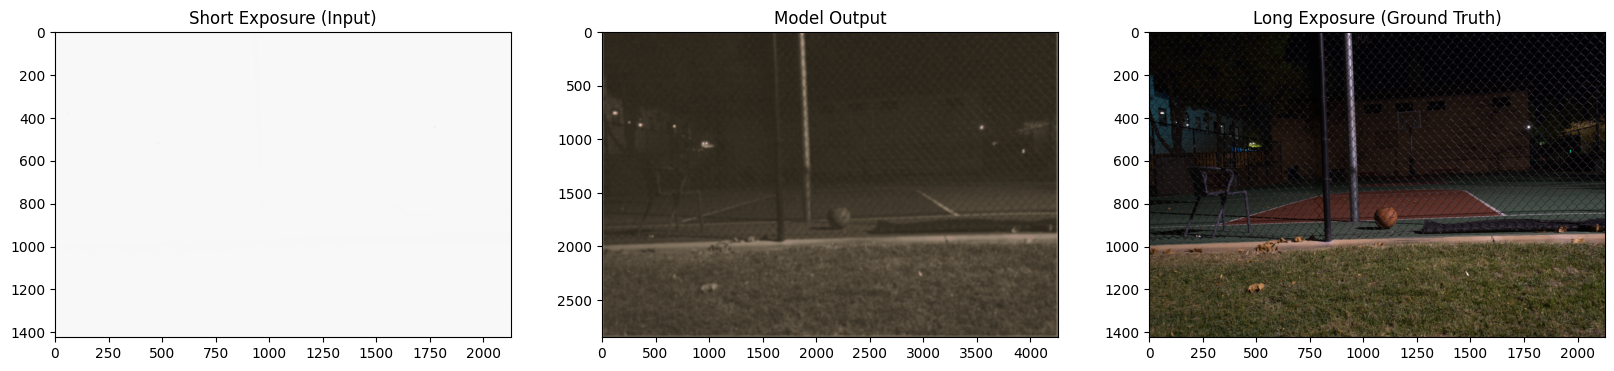

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


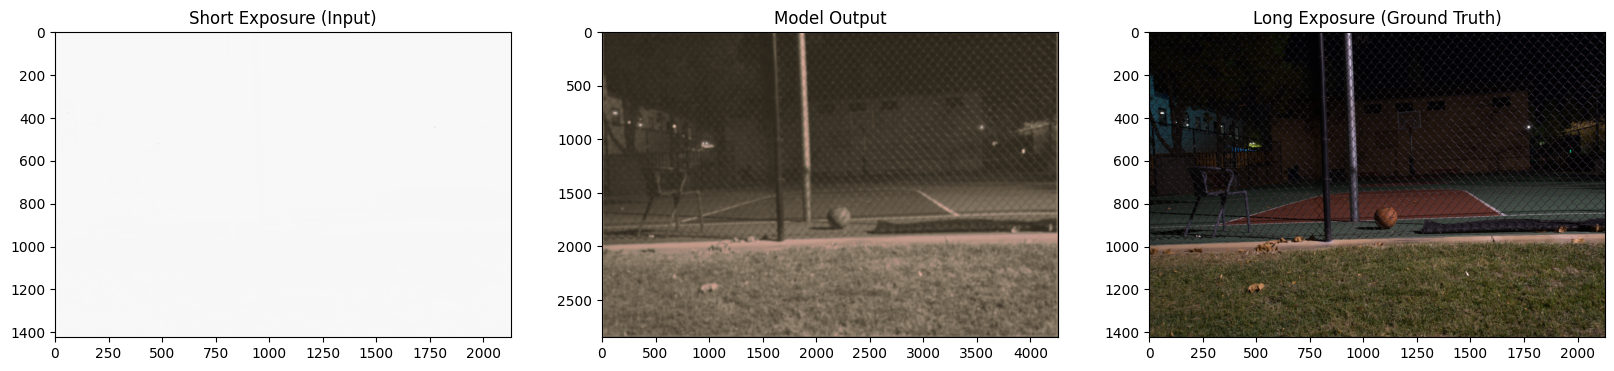

In [41]:
for short_img, long_img in test_dataset.take(2):
    pred_img = model.predict(short_img)

    fig, axes = plt.subplots(1, 3, figsize=(20, 10))

    # first sample in batch
    axes[0].imshow(short_img[0])
    axes[0].set_title("Short Exposure (Input)")

    axes[1].imshow(pred_img[0])
    axes[1].set_title("Model Output")

    axes[2].imshow(long_img[0])
    axes[2].set_title("Long Exposure (Ground Truth)")

    plt.show()

#### Compute SSIM and PSNR Scores

- SSIM: Structural Similarity Index, close to 1.0 means high structural similarity
- PSNR: Peak Signal-to-Noise Ratio, above 25 dB is generally good

In [43]:
ssim_scores = []
psnr_scores = []
losses = []

for short_img, long_img in test_dataset:
    pred_img = model.predict(short_img, verbose=0)
    pred_img = tf.image.resize(pred_img, tf.shape(long_img)[1:3])

    loss = charbonnier_loss(long_img, pred_img).numpy().mean()
    ssim_score = tf.image.ssim(pred_img, long_img, max_val=1.0).numpy().mean()
    psnr_score = tf.image.psnr(pred_img, long_img, max_val=1.0).numpy().mean()

    losses.append(loss)
    ssim_scores.append(ssim_score)
    psnr_scores.append(psnr_score)


print(f"Average loss: {sum(losses) / len(losses):.4f}")
print(f"Average SSIM: {sum(ssim_scores) / len(ssim_scores):.4f}")
print(f"Average PSNR: {sum(psnr_scores) / len(psnr_scores):.2f} dB")

Average loss: 0.0892
Average SSIM: 0.6140
Average PSNR: 19.32 dB
